In [1]:
import pandas as pd
file_path = "/content/Fraud.csv"

df = pd.read_csv(file_path)
print("Shape:", df.shape)
df.head()


Shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [2]:
print("Missing values:\n", df.isnull().sum())

# Drop missing values
df = df.dropna()

# Drop duplicates
df = df.drop_duplicates()

print("New shape after cleaning:", df.shape)


Missing values:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64
New shape after cleaning: (6362620, 11)


isFraud
0    6354407
1       8213
Name: count, dtype: int64


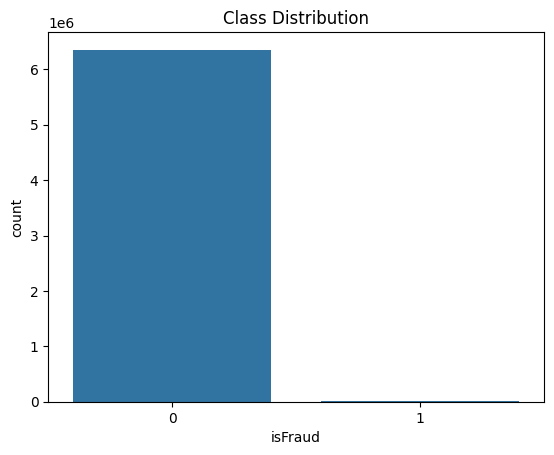

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

print(df['isFraud'].value_counts())

# Plot class distribution
sns.countplot(x='isFraud', data=df)
plt.title("Class Distribution")
plt.show()


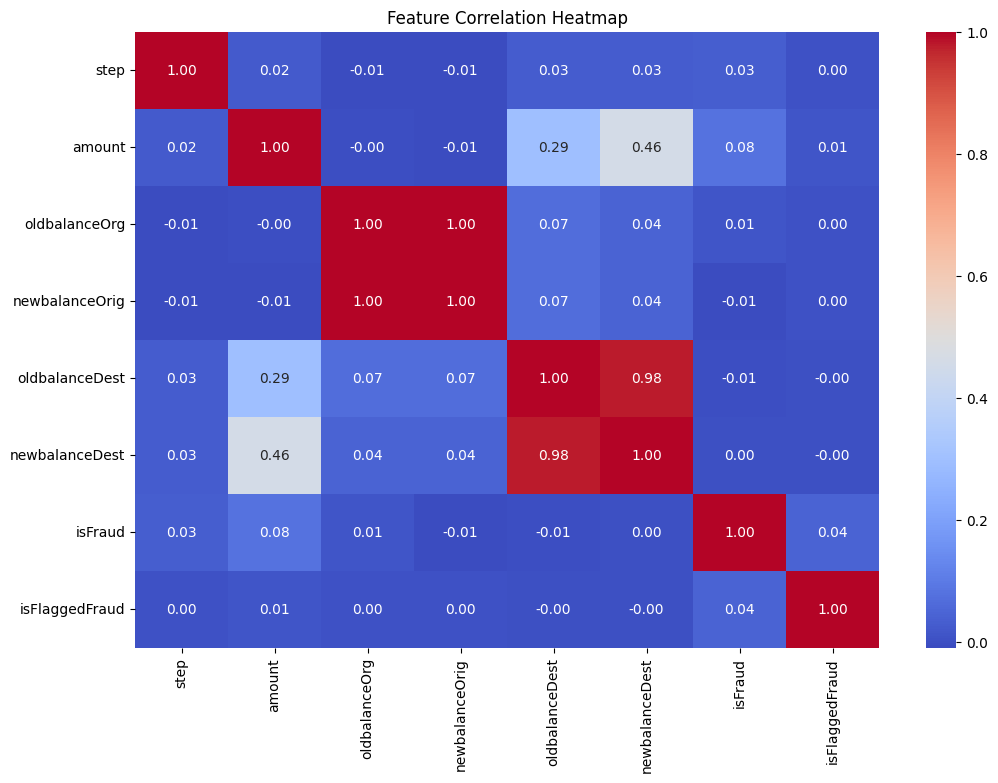

In [4]:
numeric_df = df.select_dtypes(include='number')

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


In [5]:
X = df.drop("isFraud", axis=1)
y = df["isFraud"]

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (6362620, 10)
y shape: (6362620,)


In [9]:
from sklearn.preprocessing import LabelEncoder

# Encode non-numeric features
for col in X.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
print ("All features are now numeric")


All features are now numeric


In [10]:
!pip install -q imbalanced-learn

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

print("Class distribution after SMOTE:\n", y_resampled.value_counts())


Class distribution after SMOTE:
 isFraud
0    6354407
1    6354407
Name: count, dtype: int64


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

print("split is successfull")

Model is trained and split is successfull


In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Used a small subset for quick testing
sample_size = 1000000
X_train_small = X_train_scaled[:sample_size]
y_train_small = y_train[:sample_size]

# Model dictionary
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=50, random_state=42),  # fewer trees
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=50)  # smaller model
}

# Train and evaluate each model
for name, model in models.items():
    print(f"=== Training {name} on {sample_size} samples ===")
    model.fit(X_train_small, y_train_small)
    y_pred = model.predict(X_test_scaled)
    print(f"--- {name} Classification Report ---")
    print(classification_report(y_test, y_pred))
    print("\n")


=== Training Logistic Regression on 1000000 samples ===
--- Logistic Regression Classification Report ---
              precision    recall  f1-score   support

           0       0.95      0.96      0.95   1270882
           1       0.96      0.95      0.95   1270881

    accuracy                           0.95   2541763
   macro avg       0.95      0.95      0.95   2541763
weighted avg       0.95      0.95      0.95   2541763



=== Training Random Forest on 1000000 samples ===
--- Random Forest Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270882
           1       1.00      1.00      1.00   1270881

    accuracy                           1.00   2541763
   macro avg       1.00      1.00      1.00   2541763
weighted avg       1.00      1.00      1.00   2541763



=== Training XGBoost on 1000000 samples ===


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:01:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- XGBoost Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270882
           1       1.00      1.00      1.00   1270881

    accuracy                           1.00   2541763
   macro avg       1.00      1.00      1.00   2541763
weighted avg       1.00      1.00      1.00   2541763





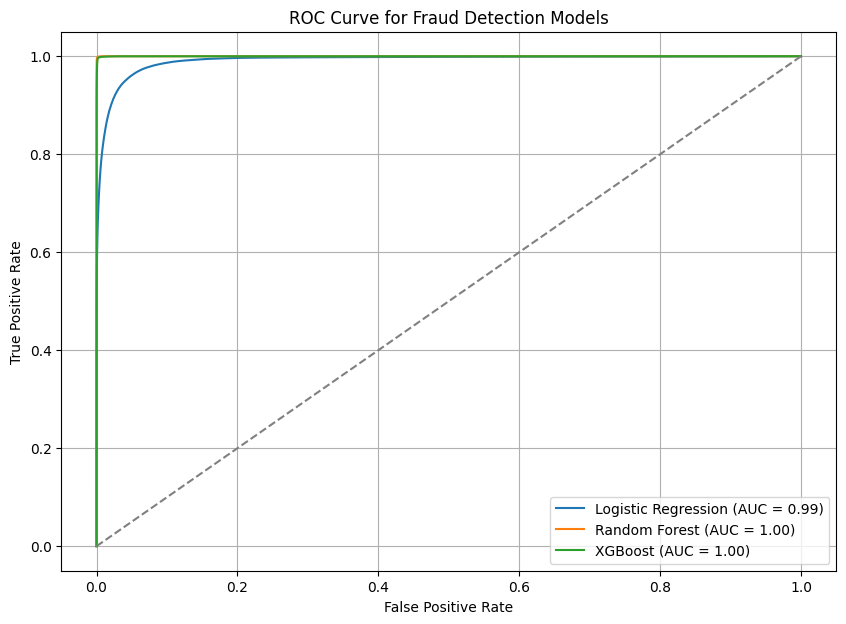

In [26]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

# Loop through each model
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test_scaled)[:, 1]  # Probability for class 1
    else:
        y_scores = model.decision_function(X_test_scaled)

    fpr, tpr, _ = roc_curve(y_test, y_scores)
    auc = roc_auc_score(y_test, y_scores)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Fraud Detection Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


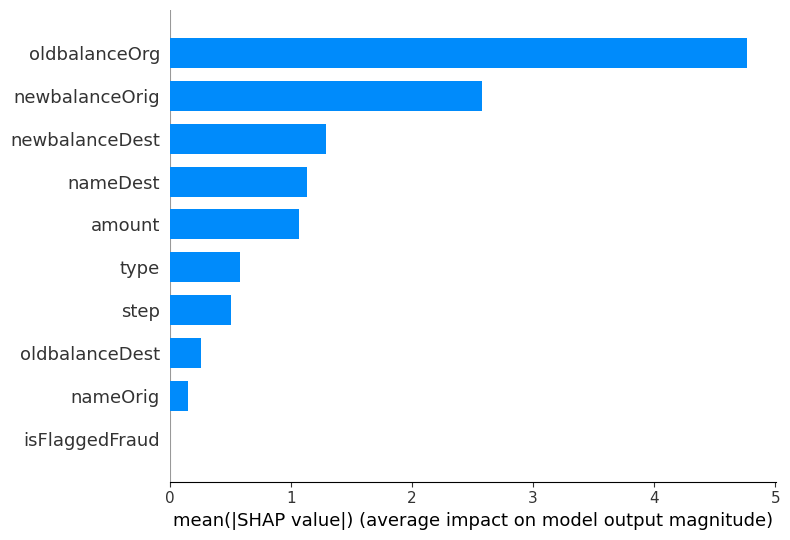

In [27]:
!pip install shap -q
import shap

# Select a small subset of test data for SHAP analysis
X_test_sample = pd.DataFrame(X_test_scaled[:1000], columns=X.columns)

# Initialize SHAP Explainer for XGBoost (change model if needed)
explainer = shap.Explainer(models["XGBoost"])
shap_values = explainer(X_test_sample)

# Summary bar plot
shap.summary_plot(shap_values, X_test_sample, plot_type="bar")


In [28]:
import joblib

# Save the best model (e.g., XGBoost) and scaler
joblib.dump(models["XGBoost"], "/content/xgboost_fraud_model.joblib")
joblib.dump(scaler, "/content/scaler.joblib")

print("Model and scaler saved.")


Model and scaler saved.
